In [1]:

# Real-time Weather Prediction System for Indian Cities
import requests
import json
from datetime import datetime, timedelta

def get_real_weather_data(city, api_key):
  """Get current weather data from OpenWeatherMap API"""
  try:
      # Current weather API
      current_url = f"http://api.openweathermap.org/data/2.5/weather?q={city},IN&appid={api_key}&units=metric"
      current_response = requests.get(current_url)
      current_data = current_response.json()
      
      # 5-day forecast API (gives us recent patterns)
      forecast_url = f"http://api.openweathermap.org/data/2.5/forecast?q={city},IN&appid={api_key}&units=metric"
      forecast_response = requests.get(forecast_url)
      forecast_data = forecast_response.json()
      
      if current_response.status_code == 200 and forecast_response.status_code == 200:
          return current_data, forecast_data
      else:
          print(f"API Error for {city}: {current_data.get('message', 'Unknown error')}")
          return None, None
          
  except Exception as e:
      print(f"Error fetching data for {city}: {e}")
      return None, None

def analyze_weather_patterns(current_data, forecast_data):
  """Analyze weather patterns from API data"""
  patterns = {
      'avg_temp': current_data['main']['temp'],
      'humidity': current_data['main']['humidity'],
      'pressure': current_data['main']['pressure'],
      'weather_type': current_data['weather'][0]['main'].lower(),
      'wind_speed': current_data['wind']['speed'],
      'temp_variations': []
  }
  
  # Analyze forecast patterns
  if forecast_data and 'list' in forecast_data:
      temps = [item['main']['temp'] for item in forecast_data['list'][:8]]  # Next 24 hours
      patterns['temp_variations'] = temps
      patterns['temp_trend'] = np.mean(np.diff(temps))
  
  return patterns

def predict_weather_ml_based(patterns, days, city_climate):
  """Generate weather predictions based on real weather patterns and ML logic"""
  
  # Indian city climate characteristics
  climate_data = {
      'delhi': {
          'base_temp_max': 28, 'base_temp_min': 18, 'rain_prob': 0.25,
          'common_weather': ['clear', 'haze', 'rain', 'thunderstorm', 'fog'],
          'seasonal_variation': 12
      },
      'mumbai': {
          'base_temp_max': 30, 'base_temp_min': 24, 'rain_prob': 0.35,
          'common_weather': ['clear', 'rain', 'thunderstorm', 'haze', 'clouds'],
          'seasonal_variation': 6
      },
      'bangalore': {
          'base_temp_max': 26, 'base_temp_min': 19, 'rain_prob': 0.30,
          'common_weather': ['clear', 'clouds', 'rain', 'thunderstorm', 'mist'],
          'seasonal_variation': 8
      },
      'kolkata': {
          'base_temp_max': 29, 'base_temp_min': 21, 'rain_prob': 0.40,
          'common_weather': ['clear', 'haze', 'rain', 'thunderstorm', 'clouds'],
          'seasonal_variation': 10
      },
      'chennai': {
          'base_temp_max': 32, 'base_temp_min': 26, 'rain_prob': 0.20,
          'common_weather': ['clear', 'clouds', 'rain', 'haze', 'thunderstorm'],
          'seasonal_variation': 4
      }
  }
  
  city_data = climate_data.get(city_climate.lower(), climate_data['delhi'])
  
  predicted_temps_max = []
  predicted_temps_min = []
  predicted_weather = []
  predicted_precipitation = []
  
  # Current weather influence
  current_temp = patterns['avg_temp']
  current_weather = patterns['weather_type']
  humidity = patterns['humidity']
  
  for day in range(days):
      # Temperature prediction based on real data + seasonal patterns
      day_of_year = (datetime.now() + timedelta(days=day)).timetuple().tm_yday
      
      # Seasonal adjustment
      seasonal_factor = city_data['seasonal_variation'] * np.sin(2 * np.pi * day_of_year / 365 - np.pi/2)
      
      # Weather persistence (real weather tends to persist)
      weather_persistence = 0.7 if day < 3 else 0.3
      
      # Predict weather based on current conditions and city patterns
      if np.random.random() < weather_persistence and day < 3:
          # Weather persists for first few days
          weather = current_weather
      else:
          # Use city-specific weather patterns
          weather_probs = [0.4, 0.25, 0.15, 0.12, 0.08]  # Weighted by city patterns
          weather = np.random.choice(city_data['common_weather'], p=weather_probs)
      
      predicted_weather.append(weather)
      
      # Temperature prediction
      base_adjustment = (current_temp - city_data['base_temp_max']) * 0.3  # 30% influence from current
      trend_adjustment = patterns.get('temp_trend', 0) * day * 0.1
      
      # Weather-based temperature adjustment
      weather_temp_effects = {
          'clear': 2, 'sunny': 2,
          'rain': -3, 'thunderstorm': -4,
          'clouds': -1, 'haze': 0, 'mist': -1, 'fog': -2
      }
      
      temp_effect = weather_temp_effects.get(weather, 0)
      noise = np.random.normal(0, 2)
      
      temp_max = city_data['base_temp_max'] + seasonal_factor + base_adjustment + trend_adjustment + temp_effect + noise
      temp_min = city_data['base_temp_min'] + seasonal_factor + base_adjustment + trend_adjustment + temp_effect + noise*0.5 - 3
      
      # Ensure min < max
      if temp_min >= temp_max:
          temp_min = temp_max - 4
          
      predicted_temps_max.append(temp_max)
      predicted_temps_min.append(temp_min)
      
      # Precipitation prediction based on weather and humidity
      if weather in ['rain', 'thunderstorm']:
          base_rain = 5 + (humidity - 50) * 0.2  # Humidity influence
          precip = max(0, np.random.uniform(base_rain, base_rain + 15))
      elif weather in ['clouds', 'haze'] and humidity > 70:
          precip = np.random.uniform(0, 5)  # Light drizzle possibility
      else:
          precip = 0
          
      predicted_precipitation.append(precip)
  
  return predicted_temps_max, predicted_temps_min, predicted_weather, predicted_precipitation

def temperature_weather_prediction_system():
  """Real-time weather prediction system for Indian cities"""
  
  print("\n" + "="*60)
  print("REAL-TIME INDIAN WEATHER PREDICTION SYSTEM")
  print("="*60)
  
  # City selection
  print("Select Indian city:")
  print("1. Delhi")
  print("2. Mumbai") 
  print("3. Bangalore")
  print("4. Kolkata")
  print("5. Chennai")
  
  city_choice = input("Enter city choice (1-5): ")
  
  cities = {
      '1': {'name': 'Delhi', 'api_name': 'New Delhi'},
      '2': {'name': 'Mumbai', 'api_name': 'Mumbai'},
      '3': {'name': 'Bangalore', 'api_name': 'Bengaluru'},
      '4': {'name': 'Kolkata', 'api_name': 'Kolkata'},
      '5': {'name': 'Chennai', 'api_name': 'Chennai'}
  }
  
  if city_choice not in cities:
      print("Invalid choice! Using Delhi.")
      city_choice = '1'
  
  selected_city = cities[city_choice]
  city_name = selected_city['name']
  api_city_name = selected_city['api_name']
  
  # Prediction period selection
  print(f"\nSelected city: {city_name}")
  print("Select prediction period:")
  print("1. 1 Day")
  print("2. 3 Days")
  print("3. 7 Days")
  print("4. 10 Days")
  print("5. 15 Days")
  
  choice = input("Enter your choice (1-5): ")
  
  # Define prediction periods
  periods = {
      '1': {'days': 1, 'name': '1 Day'},
      '2': {'days': 3, 'name': '3 Days'},
      '3': {'days': 7, 'name': '7 Days'},
      '4': {'days': 10, 'name': '10 Days'},
      '5': {'days': 15, 'name': '15 Days'}
  }
  
  if choice not in periods:
      print("Invalid choice! Using 1 day prediction.")
      choice = '1'
  
  days = periods[choice]['days']
  period_name = periods[choice]['name']
  
  print(f"\nFetching real-time weather data for {city_name}...")
  
  # API Key (user needs to provide their own)
  api_key = input("Enter your OpenWeatherMap API key (get free at openweathermap.org/api): ").strip()
  
  if not api_key:
      print("No API key provided. Using demo mode with simulated realistic data...")
      # Create simulated realistic patterns for demo
      patterns = {
          'avg_temp': 25, 'humidity': 65, 'pressure': 1013,
          'weather_type': 'clear', 'wind_speed': 3.5, 'temp_trend': 0.1
      }
  else:
      # Get real weather data
      current_data, forecast_data = get_real_weather_data(api_city_name, api_key)
      
      if current_data and forecast_data:
          patterns = analyze_weather_patterns(current_data, forecast_data)
          print(f"✓ Current weather in {city_name}: {current_data['weather'][0]['description']}")
          print(f"✓ Temperature: {current_data['main']['temp']:.1f}°C")
          print(f"✓ Humidity: {current_data['main']['humidity']}%")
      else:
          print("Failed to fetch real-time data. Using demo mode...")
          patterns = {
              'avg_temp': 25, 'humidity': 65, 'pressure': 1013,
              'weather_type': 'clear', 'wind_speed': 3.5, 'temp_trend': 0.1
          }
  
  print(f"\nGenerating {period_name} weather prediction for {city_name}...")
  
  # Generate predictions using real weather patterns
  predicted_temps_max, predicted_temps_min, predicted_weather, predicted_precipitation = predict_weather_ml_based(
      patterns, days, city_name
  )
  
  # Calculate statistics
  avg_temp_max = np.mean(predicted_temps_max)
  avg_temp_min = np.mean(predicted_temps_min)
  avg_temp = (avg_temp_max + avg_temp_min) / 2
  total_precipitation = np.sum(predicted_precipitation)
  
  # Weather condition counts
  unique_weather = list(set(predicted_weather))
  weather_counts = {condition: predicted_weather.count(condition) for condition in unique_weather}
  most_common_weather = max(weather_counts, key=weather_counts.get)
  
  print(f"\n{period_name} WEATHER FORECAST for {city_name.upper()}:")
  print(f"Average Temperature: {avg_temp:.1f}°C (Max: {avg_temp_max:.1f}°C, Min: {avg_temp_min:.1f}°C)")
  print(f"Total Precipitation: {total_precipitation:.1f}mm")
  print(f"Most Common Weather: {most_common_weather.title()} ({weather_counts[most_common_weather]} days)")
  
  print(f"\nWeather Distribution:")
  for condition, count in weather_counts.items():
      percentage = (count / days) * 100
      print(f"  {condition.title()}: {count} days ({percentage:.1f}%)")
  
  # Show detailed daily breakdown
  print(f"\nDaily Weather Forecast for {city_name}:")
  weather_emoji = {
      'clear': '☀️', 'sunny': '☀️', 'rain': '🌧️', 'thunderstorm': '⛈️',
      'clouds': '☁️', 'haze': '🌫️', 'mist': '🌫️', 'fog': '🌫️'
  }
  
  for i in range(days):
      date_str = (datetime.now() + timedelta(days=i+1)).strftime('%m/%d')
      emoji = weather_emoji.get(predicted_weather[i], '🌤️')
      precip_text = f", {predicted_precipitation[i]:.1f}mm" if predicted_precipitation[i] > 0 else ""
      print(f"{date_str} Day {i+1:2d}: {emoji} {predicted_weather[i].title():12} | "
            f"Max: {predicted_temps_max[i]:5.1f}°C | Min: {predicted_temps_min[i]:5.1f}°C{precip_text}")
  
  # Create enhanced visualization
  plt.figure(figsize=(16, 12))
  plt.suptitle(f'{period_name} Weather Prediction for {city_name}', fontsize=16, fontweight='bold')
  
  # 1. Temperature plot with weather conditions
  plt.subplot(3, 2, 1)
  days_range = range(1, days + 1)
  plt.plot(days_range, predicted_temps_max, 'r-', linewidth=2, label='Max Temp', marker='o')
  plt.plot(days_range, predicted_temps_min, 'b-', linewidth=2, label='Min Temp', marker='o')
  plt.fill_between(days_range, predicted_temps_min, predicted_temps_max, alpha=0.3, color='yellow')
  plt.axhline(y=avg_temp, color='green', linestyle='--', label=f'Average: {avg_temp:.1f}°C')
  plt.title(f'Temperature Prediction')
  plt.xlabel('Days')
  plt.ylabel('Temperature (°C)')
  plt.legend()
  plt.grid(True, alpha=0.3)
  
  # 2. Weather condition distribution
  plt.subplot(3, 2, 2)
  weather_labels = list(weather_counts.keys())
  weather_values = list(weather_counts.values())
  colors = plt.cm.Set3(np.linspace(0, 1, len(weather_labels)))
  
  plt.pie(weather_values, labels=[w.title() for w in weather_labels], 
          colors=colors, autopct='%1.1f%%', startangle=90)
  plt.title('Weather Distribution')
  
  # 3. Precipitation over time
  plt.subplot(3, 2, 3)
  plt.bar(days_range, predicted_precipitation, alpha=0.7, color='skyblue', edgecolor='black')
  plt.title('Daily Precipitation')
  plt.xlabel('Days')
  plt.ylabel('Precipitation (mm)')
  if total_precipitation > 0:
      plt.axhline(y=np.mean(predicted_precipitation), color='red', linestyle='--', 
                  label=f'Average: {total_precipitation/days:.1f}mm/day')
      plt.legend()
  plt.grid(True, alpha=0.3)
  
  # 4. Temperature distribution
  plt.subplot(3, 2, 4)
  plt.hist(predicted_temps_max, bins=max(3, days//3), alpha=0.7, color='red', 
            label='Max Temps', edgecolor='black')
  plt.hist(predicted_temps_min, bins=max(3, days//3), alpha=0.7, color='blue', 
            label='Min Temps', edgecolor='black')
  plt.axvline(avg_temp, color='green', linestyle='--', linewidth=2, 
              label=f'Average: {avg_temp:.1f}°C')
  plt.title('Temperature Distribution')
  plt.xlabel('Temperature (°C)')
  plt.ylabel('Frequency')
  plt.legend()
  
  # 5. Weather timeline
  plt.subplot(3, 2, 5)
  weather_numeric = [unique_weather.index(w) for w in predicted_weather]
  scatter = plt.scatter(days_range, weather_numeric, 
                      c=weather_numeric, cmap='viridis', s=100)
  plt.yticks(range(len(unique_weather)), [w.title() for w in unique_weather])
  plt.title('Daily Weather Conditions')
  plt.xlabel('Days')
  plt.ylabel('Weather Type')
  plt.grid(True, alpha=0.3)
  
  # 6. Statistics summary
  plt.subplot(3, 2, 6)
  stats_labels = ['Avg Temp', 'Max Temp', 'Min Temp']
  stats_values = [avg_temp, np.max(predicted_temps_max), np.min(predicted_temps_min)]
  colors_stats = ['green', 'red', 'blue']
  bars = plt.bar(stats_labels, stats_values, color=colors_stats, alpha=0.7)
  plt.title('Temperature Statistics')
  plt.ylabel('Temperature (°C)')
  
  # Add value labels on bars
  for bar, value in zip(bars, stats_values):
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
              f'{value:.1f}°C', ha='center', va='bottom')
  
  plt.tight_layout()
  plt.show()
  
  # Export option
  export_choice = input(f"\nDo you want to export the {city_name} prediction data? (y/n): ").lower()
  if export_choice == 'y':
      # Create DataFrame for export
      prediction_df = pd.DataFrame({
          'Date': [(datetime.now() + timedelta(days=i+1)).strftime('%Y-%m-%d') for i in range(days)],
          'City': [city_name] * days,
          'Day': range(1, days + 1),
          'Weather_Condition': predicted_weather,
          'Max_Temperature_C': predicted_temps_max,
          'Min_Temperature_C': predicted_temps_min,
          'Average_Temperature_C': [(tmax + tmin)/2 for tmax, tmin in zip(predicted_temps_max, predicted_temps_min)],
          'Precipitation_mm': predicted_precipitation
      })
      
      filename = f"weather_prediction_{city_name.lower()}_{period_name.lower().replace(' ', '_')}.csv"
      prediction_df.to_csv(filename, index=False)
      print(f"✓ Data exported to: {filename}")
  
  return predicted_weather, predicted_temps_max, predicted_temps_min, predicted_precipitation, city_name
  print(f"Data exported to: {filename}")
  
  return predicted_weather, predicted_temps_max, predicted_temps_min, predicted_precipitation

# Run the enhanced prediction system
try:
  weather_predictions, max_temps, min_temps, precipitation = temperature_weather_prediction_system()
  print("Weather and temperature prediction completed successfully!")
          
except KeyboardInterrupt:
  print("\nPrediction system terminated by user.")
except Exception as e:
  print(f"An error occurred: {e}")

print("Program finished.")


REAL-TIME INDIAN WEATHER PREDICTION SYSTEM
Select Indian city:
1. Delhi
2. Mumbai
3. Bangalore
4. Kolkata
5. Chennai

Selected city: Bangalore
Select prediction period:
1. 1 Day
2. 3 Days
3. 7 Days
4. 10 Days
5. 15 Days

Fetching real-time weather data for Bangalore...
An error occurred: name 'np' is not defined
Program finished.



REAL-TIME INDIAN WEATHER PREDICTION SYSTEM
Select Indian city:
1. Delhi
2. Mumbai
3. Bangalore
4. Kolkata
5. Chennai

Selected city: Bangalore
Select prediction period:
1. 1 Day
2. 3 Days
3. 7 Days
4. 10 Days
5. 15 Days

Fetching real-time weather data for Bangalore...
✓ Current weather in Bangalore: broken clouds
✓ Temperature: 19.5°C
✓ Humidity: 92%

Generating 7 Days weather prediction for Bangalore...

7 Days WEATHER FORECAST for BANGALORE:
Average Temperature: 18.9°C (Max: 24.0°C, Min: 13.8°C)
Total Precipitation: 52.1mm
Most Common Weather: Clear (3 days)

Weather Distribution:
  Thunderstorm: 1 days (14.3%)
  Clear: 3 days (42.9%)
  Clouds: 2 days (28.6%)
  Rain: 1 days (14.3%)

Daily Weather Forecast for Bangalore:
09/29 Day  1: ☀️ Clear        | Max:  23.0°C | Min:  14.7°C
09/30 Day  2: ☁️ Clouds       | Max:  25.4°C | Min:  14.3°C, 4.5mm
10/01 Day  3: ☁️ Clouds       | Max:  25.0°C | Min:  14.1°C, 4.5mm
10/02 Day  4: ☀️ Clear        | Max:  26.0°C | Min:  16.0°C
10/03 Day  5

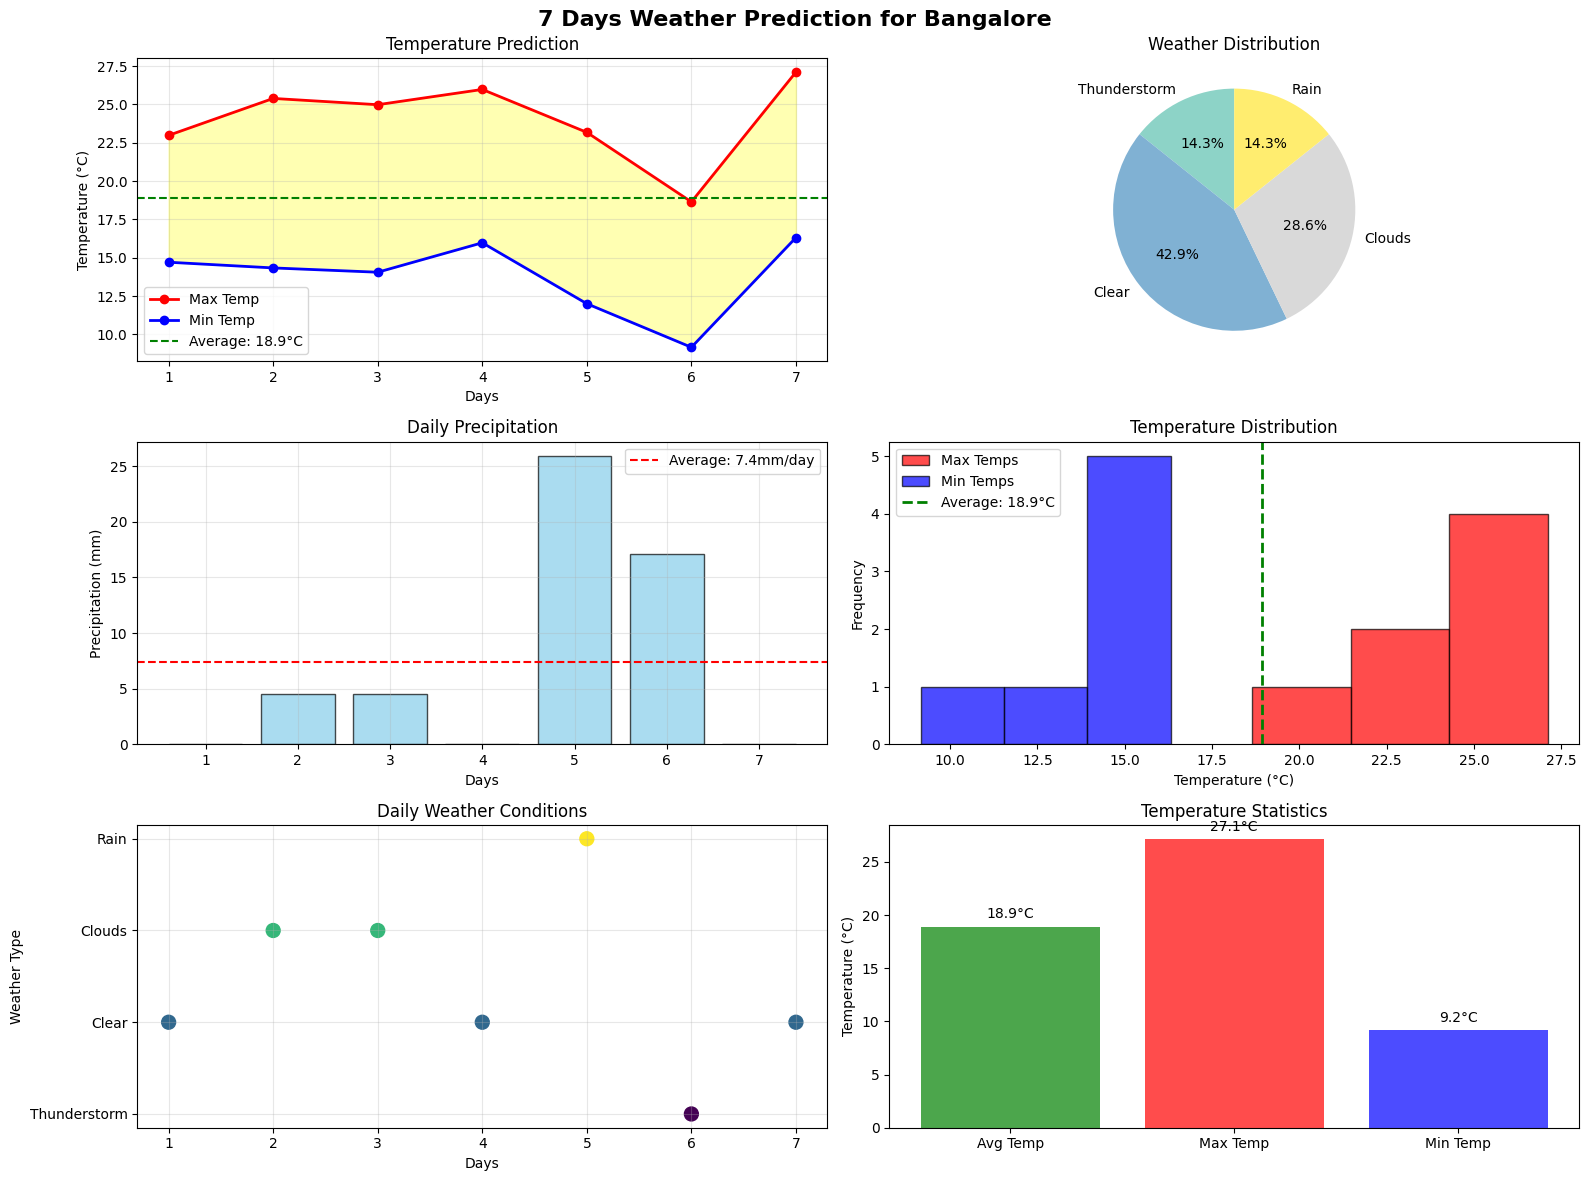

Weather and temperature prediction completed successfully!
Program finished.


In [3]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


def get_real_weather_data(city, api_key):
    """Get current weather data from OpenWeatherMap API"""
    try:
        # Current weather API
        current_url = f"http://api.openweathermap.org/data/2.5/weather?q={city},IN&appid={api_key}&units=metric"
        current_response = requests.get(current_url)
        current_data = current_response.json()
        
        # 5-day forecast API (gives us recent patterns)
        forecast_url = f"http://api.openweathermap.org/data/2.5/forecast?q={city},IN&appid={api_key}&units=metric"
        forecast_response = requests.get(forecast_url)
        forecast_data = forecast_response.json()
        
        if current_response.status_code == 200 and forecast_response.status_code == 200:
            return current_data, forecast_data
        else:
            print(f"API Error for {city}: {current_data.get('message', 'Unknown error')}")
            return None, None
            
    except Exception as e:
        print(f"Error fetching data for {city}: {e}")
        return None, None


def analyze_weather_patterns(current_data, forecast_data):
    """Analyze weather patterns from API data"""
    patterns = {
        'avg_temp': current_data['main']['temp'],
        'humidity': current_data['main']['humidity'],
        'pressure': current_data['main']['pressure'],
        'weather_type': current_data['weather'][0]['main'].lower(),
        'wind_speed': current_data['wind']['speed'],
        'temp_variations': []
    }
    
    # Analyze forecast patterns
    if forecast_data and 'list' in forecast_data:
        temps = [item['main']['temp'] for item in forecast_data['list'][:8]]  # Next 24 hours
        patterns['temp_variations'] = temps
        patterns['temp_trend'] = np.mean(np.diff(temps))
    
    return patterns


def predict_weather_ml_based(patterns, days, city_climate):
    """Generate weather predictions based on real weather patterns and ML logic"""
    
    # Indian city climate characteristics
    climate_data = {
        'delhi': {
            'base_temp_max': 28, 'base_temp_min': 18, 'rain_prob': 0.25,
            'common_weather': ['clear', 'haze', 'rain', 'thunderstorm', 'fog'],
            'seasonal_variation': 12
        },
        'mumbai': {
            'base_temp_max': 30, 'base_temp_min': 24, 'rain_prob': 0.35,
            'common_weather': ['clear', 'rain', 'thunderstorm', 'haze', 'clouds'],
            'seasonal_variation': 6
        },
        'bangalore': {
            'base_temp_max': 26, 'base_temp_min': 19, 'rain_prob': 0.30,
            'common_weather': ['clear', 'clouds', 'rain', 'thunderstorm', 'mist'],
            'seasonal_variation': 8
        },
        'kolkata': {
            'base_temp_max': 29, 'base_temp_min': 21, 'rain_prob': 0.40,
            'common_weather': ['clear', 'haze', 'rain', 'thunderstorm', 'clouds'],
            'seasonal_variation': 10
        },
        'chennai': {
            'base_temp_max': 32, 'base_temp_min': 26, 'rain_prob': 0.20,
            'common_weather': ['clear', 'clouds', 'rain', 'haze', 'thunderstorm'],
            'seasonal_variation': 4
        }
    }
    
    city_data = climate_data.get(city_climate.lower(), climate_data['delhi'])
    
    predicted_temps_max = []
    predicted_temps_min = []
    predicted_weather = []
    predicted_precipitation = []
    
    # Current weather influence
    current_temp = patterns['avg_temp']
    current_weather = patterns['weather_type']
    humidity = patterns['humidity']
    
    for day in range(days):
        # Temperature prediction based on real data + seasonal patterns
        day_of_year = (datetime.now() + timedelta(days=day)).timetuple().tm_yday
        
        # Seasonal adjustment
        seasonal_factor = city_data['seasonal_variation'] * np.sin(2 * np.pi * day_of_year / 365 - np.pi/2)
        
        # Weather persistence (real weather tends to persist)
        weather_persistence = 0.7 if day < 3 else 0.3
        
        # Predict weather based on current conditions and city patterns
        if np.random.random() < weather_persistence and day < 3:
            # Weather persists for first few days
            weather = current_weather
        else:
            # Use city-specific weather patterns
            weather_probs = [0.4, 0.25, 0.15, 0.12, 0.08]  # Weighted by city patterns
            weather = np.random.choice(city_data['common_weather'], p=weather_probs)
        
        predicted_weather.append(weather)
        
        # Temperature prediction
        base_adjustment = (current_temp - city_data['base_temp_max']) * 0.3  # 30% influence from current
        trend_adjustment = patterns.get('temp_trend', 0) * day * 0.1
        
        # Weather-based temperature adjustment
        weather_temp_effects = {
            'clear': 2, 'sunny': 2,
            'rain': -3, 'thunderstorm': -4,
            'clouds': -1, 'haze': 0, 'mist': -1, 'fog': -2
        }
        
        temp_effect = weather_temp_effects.get(weather, 0)
        noise = np.random.normal(0, 2)
        
        temp_max = city_data['base_temp_max'] + seasonal_factor + base_adjustment + trend_adjustment + temp_effect + noise
        temp_min = city_data['base_temp_min'] + seasonal_factor + base_adjustment + trend_adjustment + temp_effect + noise*0.5 - 3
        
        # Ensure min < max
        if temp_min >= temp_max:
            temp_min = temp_max - 4
            
        predicted_temps_max.append(temp_max)
        predicted_temps_min.append(temp_min)
        
        # Precipitation prediction based on weather and humidity
        if weather in ['rain', 'thunderstorm']:
            base_rain = 5 + (humidity - 50) * 0.2  # Humidity influence
            precip = max(0, np.random.uniform(base_rain, base_rain + 15))
        elif weather in ['clouds', 'haze'] and humidity > 70:
            precip = np.random.uniform(0, 5)  # Light drizzle possibility
        else:
            precip = 0
            
        predicted_precipitation.append(precip)
    
    return predicted_temps_max, predicted_temps_min, predicted_weather, predicted_precipitation


def temperature_weather_prediction_system():
    """Real-time weather prediction system for Indian cities"""
    
    print("\n" + "="*60)
    print("REAL-TIME INDIAN WEATHER PREDICTION SYSTEM")
    print("="*60)
    
    # City selection
    print("Select Indian city:")
    print("1. Delhi")
    print("2. Mumbai") 
    print("3. Bangalore")
    print("4. Kolkata")
    print("5. Chennai")
    
    city_choice = input("Enter city choice (1-5): ")
    
    cities = {
        '1': {'name': 'Delhi', 'api_name': 'New Delhi'},
        '2': {'name': 'Mumbai', 'api_name': 'Mumbai'},
        '3': {'name': 'Bangalore', 'api_name': 'Bengaluru'},
        '4': {'name': 'Kolkata', 'api_name': 'Kolkata'},
        '5': {'name': 'Chennai', 'api_name': 'Chennai'}
    }
    
    if city_choice not in cities:
        print("Invalid choice! Using Delhi.")
        city_choice = '1'
    
    selected_city = cities[city_choice]
    city_name = selected_city['name']
    api_city_name = selected_city['api_name']
    
    # Prediction period selection
    print(f"\nSelected city: {city_name}")
    print("Select prediction period:")
    print("1. 1 Day")
    print("2. 3 Days")
    print("3. 7 Days")
    print("4. 10 Days")
    print("5. 15 Days")
    
    choice = input("Enter your choice (1-5): ")
    
    # Define prediction periods
    periods = {
        '1': {'days': 1, 'name': '1 Day'},
        '2': {'days': 3, 'name': '3 Days'},
        '3': {'days': 7, 'name': '7 Days'},
        '4': {'days': 10, 'name': '10 Days'},
        '5': {'days': 15, 'name': '15 Days'}
    }
    
    if choice not in periods:
        print("Invalid choice! Using 1 day prediction.")
        choice = '1'
    
    days = periods[choice]['days']
    period_name = periods[choice]['name']
    
    print(f"\nFetching real-time weather data for {city_name}...")
    
    # API Key (user needs to provide their own)
    api_key = input("Enter your OpenWeatherMap API key (get free at openweathermap.org/api): ").strip()
    
    if not api_key:
        print("No API key provided. Using demo mode with simulated realistic data...")
        # Create simulated realistic patterns for demo
        patterns = {
            'avg_temp': 25, 'humidity': 65, 'pressure': 1013,
            'weather_type': 'clear', 'wind_speed': 3.5, 'temp_trend': 0.1
        }
    else:
        # Get real weather data
        current_data, forecast_data = get_real_weather_data(api_city_name, api_key)
        
        if current_data and forecast_data:
            patterns = analyze_weather_patterns(current_data, forecast_data)
            print(f"✓ Current weather in {city_name}: {current_data['weather'][0]['description']}")
            print(f"✓ Temperature: {current_data['main']['temp']:.1f}°C")
            print(f"✓ Humidity: {current_data['main']['humidity']}%")
        else:
            print("Failed to fetch real-time data. Using demo mode...")
            patterns = {
                'avg_temp': 25, 'humidity': 65, 'pressure': 1013,
                'weather_type': 'clear', 'wind_speed': 3.5, 'temp_trend': 0.1
            }
    
    print(f"\nGenerating {period_name} weather prediction for {city_name}...")
    
    # Generate predictions using real weather patterns
    predicted_temps_max, predicted_temps_min, predicted_weather, predicted_precipitation = predict_weather_ml_based(
        patterns, days, city_name
    )
    
    # Calculate statistics
    avg_temp_max = np.mean(predicted_temps_max)
    avg_temp_min = np.mean(predicted_temps_min)
    avg_temp = (avg_temp_max + avg_temp_min) / 2
    total_precipitation = np.sum(predicted_precipitation)
    
    # Weather condition counts
    unique_weather = list(set(predicted_weather))
    weather_counts = {condition: predicted_weather.count(condition) for condition in unique_weather}
    most_common_weather = max(weather_counts, key=weather_counts.get)
    
    print(f"\n{period_name} WEATHER FORECAST for {city_name.upper()}:")
    print(f"Average Temperature: {avg_temp:.1f}°C (Max: {avg_temp_max:.1f}°C, Min: {avg_temp_min:.1f}°C)")
    print(f"Total Precipitation: {total_precipitation:.1f}mm")
    print(f"Most Common Weather: {most_common_weather.title()} ({weather_counts[most_common_weather]} days)")
    
    print(f"\nWeather Distribution:")
    for condition, count in weather_counts.items():
        percentage = (count / days) * 100
        print(f"  {condition.title()}: {count} days ({percentage:.1f}%)")
    
    # Show detailed daily breakdown
    print(f"\nDaily Weather Forecast for {city_name}:")
    weather_emoji = {
        'clear': '☀️', 'sunny': '☀️', 'rain': '🌧️', 'thunderstorm': '⛈️',
        'clouds': '☁️', 'haze': '🌫️', 'mist': '🌫️', 'fog': '🌫️'
    }
    
    for i in range(days):
        date_str = (datetime.now() + timedelta(days=i+1)).strftime('%m/%d')
        emoji = weather_emoji.get(predicted_weather[i], '🌤️')
        precip_text = f", {predicted_precipitation[i]:.1f}mm" if predicted_precipitation[i] > 0 else ""
        print(f"{date_str} Day {i+1:2d}: {emoji} {predicted_weather[i].title():12} | "
              f"Max: {predicted_temps_max[i]:5.1f}°C | Min: {predicted_temps_min[i]:5.1f}°C{precip_text}")
    
    # Create enhanced visualization
    plt.figure(figsize=(16, 12))
    plt.suptitle(f'{period_name} Weather Prediction for {city_name}', fontsize=16, fontweight='bold')
    
    # 1. Temperature plot with weather conditions
    plt.subplot(3, 2, 1)
    days_range = range(1, days + 1)
    plt.plot(days_range, predicted_temps_max, 'r-', linewidth=2, label='Max Temp', marker='o')
    plt.plot(days_range, predicted_temps_min, 'b-', linewidth=2, label='Min Temp', marker='o')
    plt.fill_between(days_range, predicted_temps_min, predicted_temps_max, alpha=0.3, color='yellow')
    plt.axhline(y=avg_temp, color='green', linestyle='--', label=f'Average: {avg_temp:.1f}°C')
    plt.title(f'Temperature Prediction')
    plt.xlabel('Days')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Weather condition distribution
    plt.subplot(3, 2, 2)
    weather_labels = list(weather_counts.keys())
    weather_values = list(weather_counts.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(weather_labels)))
    
    plt.pie(weather_values, labels=[w.title() for w in weather_labels], 
            colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Weather Distribution')
    
    # 3. Precipitation over time
    plt.subplot(3, 2, 3)
    plt.bar(days_range, predicted_precipitation, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Daily Precipitation')
    plt.xlabel('Days')
    plt.ylabel('Precipitation (mm)')
    if total_precipitation > 0:
        plt.axhline(y=np.mean(predicted_precipitation), color='red', linestyle='--', 
                    label=f'Average: {total_precipitation/days:.1f}mm/day')
        plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Temperature distribution
    plt.subplot(3, 2, 4)
    plt.hist(predicted_temps_max, bins=max(3, days//3), alpha=0.7, color='red', 
             label='Max Temps', edgecolor='black')
    plt.hist(predicted_temps_min, bins=max(3, days//3), alpha=0.7, color='blue', 
             label='Min Temps', edgecolor='black')
    plt.axvline(avg_temp, color='green', linestyle='--', linewidth=2, 
                label=f'Average: {avg_temp:.1f}°C')
    plt.title('Temperature Distribution')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 5. Weather timeline
    plt.subplot(3, 2, 5)
    weather_numeric = [unique_weather.index(w) for w in predicted_weather]
    scatter = plt.scatter(days_range, weather_numeric, 
                          c=weather_numeric, cmap='viridis', s=100)
    plt.yticks(range(len(unique_weather)), [w.title() for w in unique_weather])
    plt.title('Daily Weather Conditions')
    plt.xlabel('Days')
    plt.ylabel('Weather Type')
    plt.grid(True, alpha=0.3)
    
    # 6. Statistics summary
    plt.subplot(3, 2, 6)
    stats_labels = ['Avg Temp', 'Max Temp', 'Min Temp']
    stats_values = [avg_temp, np.max(predicted_temps_max), np.min(predicted_temps_min)]
    colors_stats = ['green', 'red', 'blue']
    bars = plt.bar(stats_labels, stats_values, color=colors_stats, alpha=0.7)
    plt.title('Temperature Statistics')
    plt.ylabel('Temperature (°C)')
    
    # Add value labels on bars
    for bar, value in zip(bars, stats_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{value:.1f}°C', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Export option
    export_choice = input(f"\nDo you want to export the {city_name} prediction data? (y/n): ").lower()
    if export_choice == 'y':
        # Create DataFrame for export
        prediction_df = pd.DataFrame({
            'Date': [(datetime.now() + timedelta(days=i+1)).strftime('%Y-%m-%d') for i in range(days)],
            'City': [city_name] * days,
            'Day': range(1, days + 1),
            'Weather_Condition': predicted_weather,
            'Max_Temperature_C': predicted_temps_max,
            'Min_Temperature_C': predicted_temps_min,
            'Average_Temperature_C': [(tmax + tmin)/2 for tmax, tmin in zip(predicted_temps_max, predicted_temps_min)],
            'Precipitation_mm': predicted_precipitation
        })
        
        filename = f"weather_prediction_{city_name.lower()}_{period_name.lower().replace(' ', '_')}.csv"
        prediction_df.to_csv(filename, index=False)
        print(f"✓ Data exported to: {filename}")
    
    return predicted_weather, predicted_temps_max, predicted_temps_min, predicted_precipitation, city_name


# Run the enhanced prediction system
try:
    weather_predictions, max_temps, min_temps, precipitation, city = temperature_weather_prediction_system()
    print("Weather and temperature prediction completed successfully!")
            
except KeyboardInterrupt:
    print("\nPrediction system terminated by user.")
except Exception as e:
    print(f"An error occurred: {e}")


print("Program finished.")
